In [1]:
import qutip as qt
import QNN as qnn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

2024-09-18 16:29:56.580636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 16:29:56.580648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 16:29:56.581183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [2]:
df = pd.read_csv('Params/Function_5/parameters_fold_1.csv')

for i in range(2):  # Adjust the range as needed
    # Create the tuple column
    df[f'Layer{i}_bx'] = df[[f'Layer{i}_bx', f'Layer{i}_bp']].apply(tuple, axis=1)
    
    # Drop the original 'bp' column
    df = df.drop(columns=[f'Layer{i}_bp'])
    df = df.rename(columns={f'Layer{i}_bx': f'Layer{i}_bx_bp'})

In [3]:
def state(x, dim, epoch, layer, sublayer, params = df):
    
    psi = qnn.get_vacuum_state_tf(dim)
    enc = qnn.displacement_operator(dim, x, 0.0)
    psi = tf.matmul(enc, psi)
    
    if epoch == 0 or layer == 0 or sublayer == 0:
        psi = tf.squeeze(psi, axis=-1)
        psi = psi.numpy()
        return qt.Qobj(psi)
    else:
        N = layer*sublayer
        P = []
        for i in range(1,N+1):
            P.append(params[params.columns[i]][epoch+1])

    ops = [qnn.rotation_operator, qnn.squeezing_operator, qnn.rotation_operator, qnn.displacement_operator, qnn.kerr_operator]
    num_ops = len(ops)
    for i in range(N):
        op = ops[i % num_ops]
        if op == qnn.displacement_operator:
            psi = tf.matmul(op(dim, *P[i]), psi)
        else:
            psi = tf.matmul(op(dim, P[i]), psi)    

    psi = tf.squeeze(psi, axis=-1)
    psi = psi.numpy()
    
    return qt.Qobj(psi)

In [4]:
from matplotlib import cm

def wigner_plot(x, dim = 20, epoch = 1, layer = 0, sublayer = 0):
    psi = state(x, dim, epoch, layer, sublayer)

    xvec = np.linspace(-7, 7, 1000)
    pvec = xvec
    W = qt.wigner(psi, xvec, pvec)

    wmap = qt.wigner_cmap(W)  # Generate Wigner colormap
    nrm = mpl.colors.Normalize(-W.max(), W.max())
    wplot = plt.contourf(xvec, xvec, W, 100, cmap=wmap)  # Apply Wigner colormap

    da = xvec[1]-xvec[0]
    WLN = np.log(np.sum(np.abs(W)*da))
    print(f'Wigner Log Negativity: {WLN}')

    plt.title("Wigner Colormap")
    cb2 = plt.colorbar(wplot)

    #plt.tight_layout()

    plt.show()

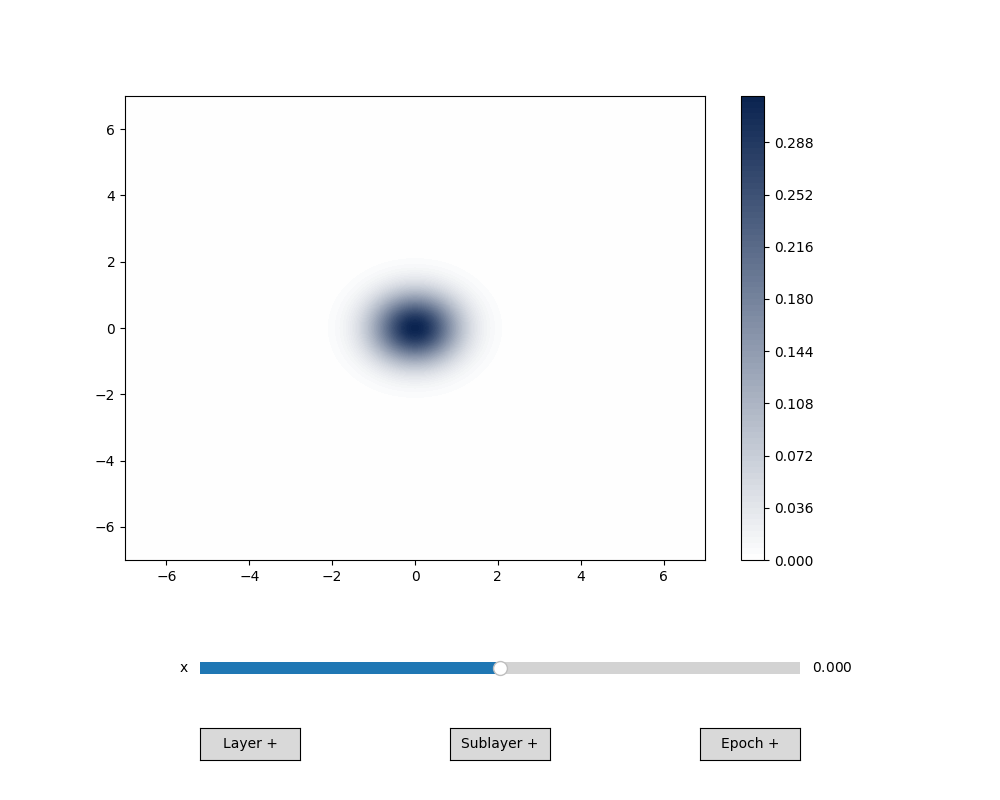

In [22]:
%matplotlib ipympl
from matplotlib.widgets import Slider, Button

plt.ion()  # Turn on interactive mode

# Assume all your previous imports and function definitions are here

fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3, right=0.85)

x_values = np.linspace(-np.pi, np.pi, 300)
x_init, dim, epoch, layer, sublayer = 0.0, 20, 1, 0, 0

# Initial plot
psi = state(float(x_init), dim, epoch, layer, sublayer)
xvec = np.linspace(-7, 7, 1000)
pvec = xvec
W = qt.wigner(psi, xvec, pvec)
wmap = qt.wigner_cmap(W)
cont = ax.contourf(xvec, xvec, W, 100, cmap=wmap)
cbar = fig.colorbar(cont, ax=ax)

def plot_wigner(x, dim, epoch, layer, sublayer):
    global cont
    psi = state(float(x), dim, epoch, layer, sublayer)
    W = qt.wigner(psi, xvec, pvec)
    
    # Clear the previous plot
    ax.clear()
    
    # Create a new contour plot
    cont = ax.contourf(xvec, xvec, W, 100, cmap=wmap)
    
    # Update colorbar
    cbar.update_normal(cont)
    
    ax.set_title(f"Wigner Plot (x={x:.4f}, epoch={epoch}, layer={layer}, sublayer={sublayer})")
    fig.canvas.draw_idle()

x_slider_ax = plt.axes([0.2, 0.15, 0.6, 0.03])
x_slider = Slider(x_slider_ax, 'x', x_values[0], x_values[-1], valinit=x_init)

layer_button_ax = plt.axes([0.2, 0.05, 0.1, 0.04])
layer_button = Button(layer_button_ax, 'Layer +')

sublayer_button_ax = plt.axes([0.45, 0.05, 0.1, 0.04])
sublayer_button = Button(sublayer_button_ax, 'Sublayer +')

epoch_button_ax = plt.axes([0.7, 0.05, 0.1, 0.04])
epoch_button = Button(epoch_button_ax, 'Epoch +')

def update(val):
    plot_wigner(float(val), dim, epoch, layer, sublayer)

def increment(var_name):
    global epoch, layer, sublayer
    if var_name == 'epoch':
        epoch += 1
    elif var_name == 'layer':
        layer += 1
    elif var_name == 'sublayer':
        sublayer += 1
    plot_wigner(float(x_slider.val), dim, epoch, layer, sublayer)

x_slider.on_changed(update)
layer_button.on_clicked(lambda _: increment('layer'))
sublayer_button.on_clicked(lambda _: increment('sublayer'))
epoch_button.on_clicked(lambda _: increment('epoch'))

plt.show(block=True)